<a href="https://colab.research.google.com/github/Nisum004/plant_disease_classification/blob/main/tea_leaves_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRANSFER LEARNING
Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second, related task. Instead of training a model from scratch, which can be time-consuming and require extensive data, transfer learning leverages the knowledge acquired during the initial training.

Instead of learning from scratch on your 35k small grayscale images,
you reuse a model that already understands vision extremely well (thanks to ImageNet’s 1.2M images).

All you do is “nudge” it to understand your specific task (like emotions).
Imagine you've learned to ride a bicycle. When you decide to learn to ride a motorcycle, you don't start from zero. You already possess valuable skills like balancing, steering, and braking, which are transferable.

Speeds up training 🕒
Requires less data 📉
Increases accuracy 📈
Reduces overfitting 🧩

This way the model trained on millions of images works to our advantage


# FREEZE LAYERS
* in simple words:
we freeze layers so that the model uses its own features i.e edges, lines, gradients, shapes, color patterns etc for classification rather than train from our small dataset

a pretrained model consists of many layers . for eg a resnet18 model has seven layers
* (conv1) → (bn1) → (layer1) → (layer2) → (layer3) → (layer4) → (fc)

When you load a pretrained model like ResNet18 trained on ImageNet, it already knows:
* Low-level features: edges, corners, gradients
* Mid-level features: textures, shapes, color patterns
* High-level features: object parts (eyes, noses, wheels, etc.)

If your dataset is small (like emotion faces), you don’t want to destroy those useful filters.
So when you freeze them (param.requires_grad = False):
You keep the already-learned filters fixed.
You only train a new classifier on top of them.


# FINE TUNE A PRETRAINED MODEL
Fine-tuning means you unfreeze some deeper layers (e.g., layer4 in ResNet18).

These layers learn more specific visual features that depend on your dataset.

You freeze early layers → keep general vision knowledge.

You fine-tune deeper layers → adapt to your custom dataset.

For example, in your emotion dataset:
Edges and corners (early layers) are the same as ImageNet.
But “smiling” vs “frowning” — those are high-level facial features — so the last few layers need to adjust.


#1. IMPORT LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

#2. TRAIN MODEL ARCHITECTURE

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, fine_tuning = False):
  best_model_params_path = os.path.join(tmpdir, 'best_model_params.pt')
  torch.save(model.state_dict(), best_model_params_path)
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _,preds = torch.max(outputs,1)

          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase}\nLoss:{epoch_loss:.4f}|acc:{epoch_acc:.4f}')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), best_model_params_path)
  print('\n Training complete')
  print(f'\n best accuracy: {best_acc:.4f}')

  # FINE TUNING. # Now we unfreeze few last layers and train the model again
  if fine_tuning:
    print("\n Starting Fine-Tuning")
    for name,param in model.named_parameters():
      if 'layer4' in name or 'fc' in name:   # unfreeze last layers
        param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
    for epoch in range(5):   # we choose 5 as finetuning epoch
      print(f"\n Fine tune epoch: {epoch+1}/5")
      model.train()
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders['train']:
        inputs,labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _,preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_sizes['train']
      epoch_acc = running_corrects.double()/dataset_sizes['train']
      print(f"Fine-tuning loss: {epoch_loss:.4f}|Fine-tuning acc: {epoch_acc:.4f}")

  return model


#3. PREPARE DATA

In [ ]:
# DATA PATH:
data_dir = '/content/drive/MyDrive/tea_leaves_ds'
train_path = os.path.join(data_dir,'train')
test_path = os.path.join(data_dir, 'test')

In [ ]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


#4. MAIN CODE


In [ ]:
if __name__ == '__main__':

  # Load Datasets
  train_data = datasets.ImageFolder(train_path, transform = data_transform['train'])
  test_data = datasets.ImageFolder(test_path, transform = data_transform['test'])

  image_datasets = {'train': train_data, 'test': test_data}

  # DataLoaders
  dataloaders = {
      'train': torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 2),
      'test': torch.utils.data.DataLoader(test_data, batch_size = 4, shuffle = False, num_workers = 2)
  }

  # Dataset sizes
  dataset_sizes = {
      'train': len(image_datasets['train']),
      'test': len(image_datasets['test'])
  }
  print('Dataset_size: ', dataset_sizes['train'], dataset_sizes['test'])
  class_names = image_datasets['train'].classes

  # DEVICE
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device: ' , device)
  print('Classes: ', class_names)

  # MODEL SETUP

  model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

  # FREEZE ALL LAYERS FIRST
  for params in model.parameters():
    params.requires_grad = False

  # Replace final layer (fine tuning)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, len(class_names))
  model = model.to(device)

  # LOSS + OPTIMIZER + SCHEDULER
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma = 0.1)

  # TRAIN MODEL
  model = train_model(model, criterion, optimizer, scheduler, num_epochs = 10, fine_tuning = True)

  #SAVE MODEL
  torch.save(model.state_dict(), 'leaf_resnet18_finetuned.pt')

  print('SAved successfully')

#5.LOAD MODEL AND PREDICT IMAGE

pred: tensor([5], device='cuda:0')


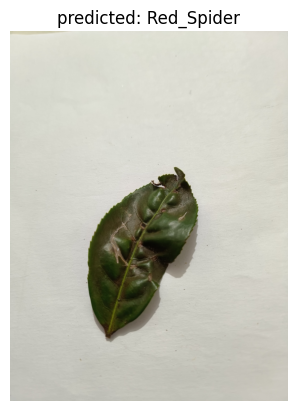


 Final Prediction: Red_Spider


In [39]:

# Load model
model.load_state_dict(torch.load('leaf_resnet18_finetuned.pt', map_location= device))
model.eval()

# Define data transforms (should match the test transform used in training)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# DATA PATH:
data_dir = '/content/drive/MyDrive/tea_leaves_ds'
test_path = os.path.join(data_dir, 'test')

# Load the dataset to get class names
test_data = datasets.ImageFolder(test_path, transform=transform)
class_names = test_data.classes


# load and preprocess images
img_path = '/content/drive/MyDrive/tea_leaves_ds/test/Red_Spider/red_spider_00182.jpg' # You need to provide the path to your image here
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# PREDICT
with torch.no_grad():
  output = model(input_tensor)
  _, pred = torch.max(output, 1)
  print("pred:", pred)
  predicted_class = class_names[pred.item()]

plt.imshow(image)
plt.title(f"predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"\n Final Prediction: {predicted_class}")